# Modelling Code

In [1]:
import nltk
import functools
import operator
import nltk
import itertools
import gdelt
from nltk.corpus import stopwords
import pandas as pd
from datetime import datetime 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wget
import requests

Read the USA China Data

In [2]:
us_chn_data = pd.read_csv("fin_test")

In [3]:
us_chn_data

,SQLDATE,Actor1Code,Actor2Code,EventCode,DATEADDED,ActionGeo_Lat,ActionGeo_Long,NumMentions,AvgTone,QuadClass,GoldsteinScale,NumArticles,SOURCEURL
0,20200301,CHN,USA,256,20200301200000,35.0000,105.000,3,-2.698023,1,-0.3,3,http://www.wboc.com/story/41836455/virus-cases...
1,20200302,CHN,USA,256,20200302000000,35.0000,105.000,6,-2.781947,1,-0.3,6,https://www.wiscnews.com/news/world/virus-acce...
2,20200302,USA,CHN,192,20200302123000,35.0000,105.000,8,-0.351494,4,-9.5,8,https://www.thesundaily.my/opinion/birds-of-a-...
3,20200302,CHN,USA,15,20200302174500,35.0000,105.000,10,-18.243243,1,0.0,10,https://www.wwnytv.com/2020/03/02/robinson-ple...
4,20200302,USA,CHN,15,20200302174500,35.0000,105.000,4,-18.243243,1,0.0,2,https://www.wwnytv.com/2020/03/02/robinson-ple...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3620,20190416,USA,CHN,174,20200415184500,39.9289,116.388,2,-4.403048,4,-5.0,2,https://thediplomat.com/2020/04/covid-19-will-...
3621,20200416,USA,CHN,163,20200416081500,39.9289,116.388,1,-3.926097,4,-8.0,1,https://www.telegraph.co.uk/politics/2020/04/1...
3622,20200416,CHN,USA,183,20200416190000,39.9289,116.388,2,-7.387863,4,-10.0,2,https://www.taipeitimes.com/News/world/archive...
3623,20200317,USA,CHN,193,20200416153000,39.9289,116.388,4,-3.011204,4,-10.0,4,https://www.japantimes.co.jp/2020/04/17/


Aggregate by Dates

In [3]:
new_data = us_chn_data.groupby('SQLDATE', as_index=False, sort=False)['GoldsteinScale'].mean()
format_str = '%Y%m%d'
new_data.SQLDATE = [datetime.strptime(str(x), format_str) for x in new_data.SQLDATE]
goldstein = new_data[new_data.SQLDATE > datetime(2020,2,29)].sort_values(by="SQLDATE")

In [4]:
new_data = us_chn_data.groupby('SQLDATE', as_index=False, sort=False)['AvgTone'].mean()
new_data.SQLDATE = [datetime.strptime(str(x), format_str) for x in new_data.SQLDATE]
tone = new_data[new_data.SQLDATE > datetime(2020,2,29)].sort_values(by="SQLDATE")

In [5]:
total_data = pd.merge(tone, goldstein, on="SQLDATE")
total_data["SQLDATE"] = pd.to_datetime(total_data["SQLDATE"])

In [6]:
goldstein.tail()

,SQLDATE,GoldsteinScale
68,2020-04-25,1.159459
70,2020-04-26,1.585294
69,2020-04-27,0.615385
49,2020-04-28,-0.274026
50,2020-04-29,-2.288406


Calculate dow daily changes, and merge

In [7]:
dow = pd.read_csv("dow.csv")
dow["Diff"] = dow["Open"] - dow["Close"]
dow["Date"] = pd.to_datetime(dow["Date"])

In [8]:
merging_data = pd.merge(total_data, dow["Date"], how="left", left_on="SQLDATE", right_on="Date")
merging_data.head()

,SQLDATE,AvgTone,GoldsteinScale,Date
0,2020-03-01,-2.669227,-1.296000,NaT
1,2020-03-02,-2.298869,-1.674000,2020-03-02
2,2020-03-03,-3.788864,-3.372414,2020-03-03
3,2020-03-04,-3.350338,-3.457692,2020-03-04
4,2020-03-05,-2.504286,0.081395,2020-03-05


Algorithm which merges weekend and any missing data into previous day figures

In [9]:
def merge_column(df, cols):
    new_df = pd.DataFrame()
    date_match = df["Date"]
    fst_occurrence = np.where(pd.isnull(date_match))[0][0]
    if fst_occurrence == 0:
        true_fst_occurrence = date_match.first_valid_index()
        df = df.iloc[true_fst_occurrence:]
        date_match = df["Date"]
    
    for i in cols:
        col_value = df[i]
        new_col = []
        j = 0
        while j < len(date_match):
            n = 1
            if (j+n) < len(date_match) and pd.isnull(date_match[j + n]):
                total = col_value.iloc[j]
                while (j+n) < len(date_match) and pd.isnull(date_match[j + n]):
                    total = total + col_value.iloc[j + n]
                    n = n + 1
                new_col.append(total/n)
            else:
                new_col.append(col_value.iloc[j])
    
            j = j + n 
        
        
        new_df[i] = new_col

    not_null = date_match[date_match.notnull()]
    new_df["Date"] = not_null.reset_index(drop=True)
    
    return new_df

In [10]:
final_df = merge_column(merging_data, ["GoldsteinScale", "AvgTone"])

In [11]:
final_df = pd.merge(final_df, dow, on="Date")

In [12]:
final_df.set_index('Date', inplace=True)

In [13]:
final_df.drop(["Open", "Close", "Low", "High", "Adj Close", "Volume"], axis=1, inplace=True)

Turn difference binary, 0 represents a fall, 1 represents a rise

In [14]:
def func(x):
    if x < 0:
        return 0 
    if x > 0:
        return 1 
    return 0

In [15]:
final_df["Diff"] = final_df["Diff"].apply(func)

In [16]:
final_df.dtypes

GoldsteinScale    float64
AvgTone           float64
Diff                int64
dtype: object

In [17]:
final_df.Diff = final_df.Diff.shift(-1)

In [18]:
final_df.drop(final_df.tail(1).index, inplace=True)

In [19]:
final_df.head()

,GoldsteinScale,AvgTone,Diff
Date,,,
2020-03-02,-1.674000,-2.298869,1.0
2020-03-03,-3.372414,-3.788864,0.0
2020-03-04,-3.457692,-3.350338,1.0
2020-03-05,0.081395,-2.504286,0.0
2020-03-06,-1.303922,-2.169450,1.0


## Classifiers

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score

In [21]:
def split(final_df):
    X = final_df.drop("Diff", axis=1)
    Y = final_df["Diff"]
    return train_test_split(X, Y, stratify=Y, random_state=42, test_size=0.2)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

In [23]:
random_state = 7

def rf(X_train, X_test, Y_train, Y_test):
    forest = RandomForestClassifier(random_state=random_state)
    forest.fit(X_train, Y_train)
    predict = forest.predict(X_test)
    accuracy = accuracy_score(Y_test, predict)
    print(accuracy)
    return forest, accuracy

def log(X_train, X_test, Y_train, Y_test):
    log = LogisticRegression(random_state=random_state)
    log.fit(X_train, Y_train)
    predict = log.predict(X_test)
    accuracy = accuracy_score(Y_test, predict)
    print(accuracy)
    return log, accuracy

def nb(X_train, X_test, Y_train, Y_test):
    regr = BernoulliNB()
    regr.fit(X_train, Y_train)
    predict = regr.predict(X_test)
    accuracy = accuracy_score(Y_test, predict)
    print(accuracy)
    return regr, accuracy

def svm(X_train, X_test, Y_train, Y_test):
    svm = SVC(random_state=random_state)
    svm.fit(X_train, Y_train)
    predict = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, predict)
    print(accuracy)
    return svm, accuracy

In [24]:
Results = []

## No Smoothing

In [25]:
copy_df = final_df.copy()
X_train, X_test, Y_train, Y_test = split(copy_df) 

nb_clf, acc_nb_clf = nb(X_train, X_test, Y_train, Y_test)
log_clf, acc_log_clf = log(X_train, X_test, Y_train, Y_test)
rf_clf, acc_rf_clf = rf(X_train, X_test, Y_train, Y_test)
svm_clf, acc_svm_clf = svm(X_train, X_test, Y_train, Y_test)

0.4444444444444444
0.3333333333333333
0.4444444444444444
0.4444444444444444


In [26]:
copy_df["prev_day"] = copy_df["Diff"].shift(1)
copy_df.dropna(inplace=True)

In [27]:
X_train, X_test, Y_train, Y_test = split(copy_df) 

nb_clf_p, acc_nb_clf_p = nb(X_train, X_test, Y_train, Y_test)
log_clf_p, acc_log_clf_p = log(X_train, X_test, Y_train, Y_test)
rf_clf_p, acc_rf_clf_p = rf(X_train, X_test, Y_train, Y_test)
svm_clf_p, acc_svm_clf_p = svm(X_train, X_test, Y_train, Y_test)

0.75
0.75
0.625
0.625


In [28]:
Results = Results + ([
    ("nb_clf_p", nb_clf_p, acc_nb_clf_p), 
    ("log_clf_p", log_clf_p, acc_log_clf_p), 
    ("rf_clf_p", rf_clf_p, acc_rf_clf_p), 
    ("svm_clf_p", svm_clf_p, acc_svm_clf_p)
])

## Using average lag, so each day is weighted the same

In [29]:
copy_df = final_df.copy()
k=3
copy_df.GoldsteinScale = copy_df["GoldsteinScale"].rolling(k).mean()
copy_df.AvgTone = copy_df["AvgTone"].rolling(k).mean()
copy_df.drop(final_df.head(k-1).index, inplace=True)

In [30]:
X_train, X_test, Y_train, Y_test = split(copy_df) 

nb_clf_a, acc_nb_clf_a = nb(X_train, X_test, Y_train, Y_test)
log_clf_a, acc_log_clf_a = log(X_train, X_test, Y_train, Y_test)
rf_clf_a, acc_rf_clf_a = rf(X_train, X_test, Y_train, Y_test)
svm_clf_a, acc_svm_clf_a = svm(X_train, X_test, Y_train, Y_test)

0.625
0.25
0.625
0.5


In [31]:
copy_df["prev_day"] = copy_df["Diff"].shift(1)
copy_df.dropna(inplace=True)

In [32]:
X_train, X_test, Y_train, Y_test = split(copy_df) 

a_nb_clf_p, acc_a_nb_clf_p = nb(X_train, X_test, Y_train, Y_test)
a_log_clf_p, acc_a_log_clf_p = log(X_train, X_test, Y_train, Y_test)
a_rf_clf_p, acc_a_rf_clf_p = rf(X_train, X_test, Y_train, Y_test)
a_svm_clf_p, acc_a_svm_clf_p = svm(X_train, X_test, Y_train, Y_test)

0.625
0.625
0.75
0.625


In [33]:
Results = Results + ([

("a_nb_clf_p", a_nb_clf_p, acc_a_nb_clf_p),
("a_log_clf_p", a_log_clf_p, acc_a_log_clf_p),
("a_rf_clf_p", a_rf_clf_p, acc_a_rf_clf_p),
("a_svm_clf_p", a_svm_clf_p, acc_a_svm_clf_p)

]) 

## Using Gaussian smoothing so effect of x days is prevalent, but not the same

In [34]:
from scipy.stats import norm
import math

def half_gaussian_convolution(input):
    normal_weighting = norm.pdf(np.array(range(-len(input) + 1, 1)), scale=(len(input) - 1) / 1.6448536269514722)
    normal_weighting = normal_weighting / np.sum(normal_weighting)
    return np.sum(normal_weighting * input)


In [35]:
k=3 
gauss_df = final_df.copy()
gauss_df.GoldsteinScale = gauss_df["GoldsteinScale"].rolling(k).apply(func=half_gaussian_convolution)
gauss_df.AvgTone = gauss_df["AvgTone"].rolling(k).apply(func=half_gaussian_convolution)
gauss_df.dropna(inplace=True)

In [36]:
X_train, X_test, Y_train, Y_test = split(gauss_df) 

nb_clf_g, acc_nb_clf_g = nb(X_train, X_test, Y_train, Y_test)
log_clf_g, acc_log_clf_g = log(X_train, X_test, Y_train, Y_test)
rf_clf_g, acc_rf_clf_g = rf(X_train, X_test, Y_train, Y_test)
svm_clf_g, acc_svm_clf_g = svm(X_train, X_test, Y_train, Y_test)

0.375
0.25
0.625
0.5


In [37]:
gauss_df["prev_day"] = gauss_df["Diff"].shift(1)
gauss_df.dropna(inplace=True)

In [38]:
X_train, X_test, Y_train, Y_test = split(gauss_df) 

g_nb_clf_p, acc_g_nb_clf_p = nb(X_train, X_test, Y_train, Y_test)
g_log_clf_p, acc_g_log_clf_p = log(X_train, X_test, Y_train, Y_test)
g_rf_clf_p, acc_g_rf_clf_p = rf(X_train, X_test, Y_train, Y_test)
g_svm_clf_p, acc_g_svm_clf_p = svm(X_train, X_test, Y_train, Y_test)

0.625
0.625
0.75
0.625


In [39]:
Results = Results + ([

("g_nb_clf_p", g_nb_clf_p, acc_g_nb_clf_p),
("g_log_clf_p", g_log_clf_p, acc_g_log_clf_p),
("g_rf_clf_p", g_rf_clf_p, acc_g_rf_clf_p),
("g_svm_clf_p", g_svm_clf_p, acc_g_svm_clf_p)

]) 

## Exponential Smoothing

In [40]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [41]:
exp_smooth = final_df.copy()

In [42]:
exp_smooth.GoldsteinScale = exp_smooth.GoldsteinScale.ewm(span=3).mean()
exp_smooth.AvgTone = exp_smooth.AvgTone.ewm(span=3).mean()

In [43]:
X_train, X_test, Y_train, Y_test = split(exp_smooth) 

nb_clf_e, acc_nb_clf_e = nb(X_train, X_test, Y_train, Y_test)
log_clf_e, acc_log_clf_e = log(X_train, X_test, Y_train, Y_test)
rf_clf_e, acc_rf_clf_e = rf(X_train, X_test, Y_train, Y_test)
svm_clf_e, acc_svm_clf_e = svm(X_train, X_test, Y_train, Y_test)

0.4444444444444444
0.4444444444444444
0.2222222222222222
0.4444444444444444


In [44]:
exp_smooth["prev_day"] = exp_smooth["Diff"].shift(1)
exp_smooth.dropna(inplace=True)

In [45]:
X_train, X_test, Y_train, Y_test = split(exp_smooth) 

e_nb_clf_p, acc_e_nb_clf_p = nb(X_train, X_test, Y_train, Y_test)
e_log_clf_p, acc_e_log_clf_p = log(X_train, X_test, Y_train, Y_test)
e_rf_clf_p, acc_e_rf_clf_p = rf(X_train, X_test, Y_train, Y_test)
e_svm_clf_p, acc_e_svm_clf_p = svm(X_train, X_test, Y_train, Y_test)

0.75
0.75
0.75
0.625


In [46]:
Results = Results + ([

("e_nb_clf_p", e_nb_clf_p, acc_e_nb_clf_p),
("e_log_clf_p", e_log_clf_p, acc_e_log_clf_p),
("e_rf_clf_p", e_rf_clf_p, acc_e_rf_clf_p),
("e_svm_clf_p", e_svm_clf_p, acc_e_svm_clf_p)

])

## Neural Net

In [48]:
import tensorflow as tf
from tensorflow import keras

In [49]:
from tensorflow.keras.layers import *

In [176]:
tf.random.set_seed(42)

In [177]:
nn_df = final_df.copy()

In [178]:
nn_df["Diff"] = [int(i) for i in nn_df["Diff"]]

In [179]:
nn_df["prev_day"] = nn_df["Diff"].shift(1)
nn_df.dropna(inplace=True)

In [180]:
X_train, X_test, Y_train, Y_test = split(nn_df) 

In [181]:
model = keras.Sequential()

In [ ]:
model.add(keras.layers.Input(shape=X_train.shape[1:]))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.optimizers import *

In [ ]:
model.compile(
    optimizer=keras.optimizers.SGD(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(
    X_train,
    Y_train,
    epochs=30,
    verbose=0,
#     validation_data=(X_test, Y_test),
)

In [ ]:
model.evaluate(X_test, Y_test)

In [ ]:
Results.append(("nn", model, 0.5))

## Manual Lagging

In [47]:
man_lag = final_df.copy()

for i in ["GoldsteinScale", "AvgTone"]:
    for j in range(1,5):
        man_lag[i + str(j)] = man_lag[i].shift(j)

In [48]:
man_lag.dropna(inplace=True)

In [49]:
from statsmodels.regression.linear_model import OLS

In [50]:
X_train, X_test, Y_train, Y_test = split(man_lag) 

nb_clf_man, acc_nb_clf_man = nb(X_train, X_test, Y_train, Y_test)
log_clf_man, acc_log_clf_man = log(X_train, X_test, Y_train, Y_test)
rf_clf_man, acc_rf_clf_man = rf(X_train, X_test, Y_train, Y_test)
svm_clf_man, acc_svm_clf_man = svm(X_train, X_test, Y_train, Y_test)

0.375
0.25
0.375
0.375


In [51]:
man_lag["prev_day"] = man_lag["Diff"].shift(1)
man_lag.dropna(inplace=True)

In [52]:
X_train, X_test, Y_train, Y_test = split(man_lag) 

man_nb_clf_p, acc_man_nb_clf_p = nb(X_train, X_test, Y_train, Y_test)
man_log_clf_p, acc_man_log_clf_p = log(X_train, X_test, Y_train, Y_test)
man_rf_clf_p, acc_man_rf_clf_p = rf(X_train, X_test, Y_train, Y_test)
man_svm_clf_p, acc_man_svm_clf_p = svm(X_train, X_test, Y_train, Y_test)

0.5
0.5
0.625
0.375


In [53]:
Results = Results + ([

("man_nb_clf_p", man_nb_clf_p, acc_man_nb_clf_p),
("man_log_clf_p", man_log_clf_p, acc_man_log_clf_p),
("man_rf_clf_p", man_rf_clf_p, acc_man_rf_clf_p),
("man_svm_clf_p", man_svm_clf_p, acc_man_svm_clf_p)

])


## OLS

In [57]:
ols = OLS(Y_train, X_train)

In [58]:
res = ols.fit()

In [59]:
res.params

GoldsteinScale    -0.051478
AvgTone           -0.255230
GoldsteinScale1   -0.057975
GoldsteinScale2   -0.006400
GoldsteinScale3    0.094149
GoldsteinScale4    0.018423
AvgTone1           0.311692
AvgTone2          -0.099537
AvgTone3          -0.336495
AvgTone4           0.156176
prev_day          -0.575584
dtype: float64

In [60]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Diff   R-squared (uncentered):                   0.735
Model:                            OLS   Adj. R-squared (uncentered):              0.563
Method:                 Least Squares   F-statistic:                              4.280
Date:                Sun, 09 Aug 2020   Prob (F-statistic):                     0.00375
Time:                        17:10:16   Log-Likelihood:                         -11.449
No. Observations:                  28   AIC:                                      44.90
Df Residuals:                      17   BIC:                                      59.55
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
GoldsteinScale     -0.0515      0.115     -0.446      0.661      -0.295       0.192
AvgTone            -0.2552      0.190     -1.345      0.196      -0.656       0.145
GoldsteinScale1    -0.0580      0.100     -0.578      0.571      -0.270       0.154
GoldsteinScale2    -0.0064      0.107     -0.060      0.953      -0.233       0.220
GoldsteinScale3     0.0941      0.098      0.956      0.352      -0.114       0.302
GoldsteinScale4     0.0184      0.097      0.191      0.851      -0.185       0.222
AvgTone1            0.3117      0.223      1.396      0.181      -0.159       0.783
AvgTone2           -0.0995      0.212     -0.470      0.644      -0.546       0.347
AvgTone3           -0.3365      0.218     -1.543      0.141      -0.797       0.124
AvgTone4            0.1562      0.175      0.893      0.385      -0.213       0.525
prev_day           -0.5756      0.196     -2.931      0.009      -0.990      -0.161
==============================================================================
Omnibus:                        0.557   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.757   Jarque-Bera (JB):                0.537
Skew:                          -0.296   Prob(JB):                        0.764
Kurtosis:                       2.667   Cond. No.                         26.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
res.predict(X_test)

Date
2020-04-15    0.475883
2020-03-11   -0.490553
2020-03-27    0.031453
2020-04-07    0.563550
2020-04-21    0.417322
2020-03-20    0.353223
2020-03-25    1.172797
2020-04-09    0.513153
dtype: float64

In [ ]:
Y_test

## Calculating the Best Model

In [54]:
sort = sorted(Results, key=lambda x: x[2], reverse=True)

In [55]:
[i[2] for i in sort]

[0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.625,
 0.625,
 0.625,
 0.625,
 0.625,
 0.625,
 0.625,
 0.625,
 0.625,
 0.625,
 0.5,
 0.5,
 0.375]

sort = sort[0:6]

In [56]:
[i[0] for i in sort[0:7]]

['nb_clf_p',
 'log_clf_p',
 'a_rf_clf_p',
 'g_rf_clf_p',
 'e_nb_clf_p',
 'e_log_clf_p',
 'e_rf_clf_p']

I pick the exponentially smoothed random forest. Random forests did well in all examples, and if the results are tied (although on a tiny sample size) I will pick the classifier with the best overall result

In [57]:
results = pd.DataFrame([(str(i[0]), i[2]) for i in sort], columns=['Classifier', 'Accuracy',])

In [58]:
results.Classifier = results.Classifier.str.replace("_clf_p", "")
results.Classifier = results.Classifier.str.replace("a_", "Averaged ")
results.Classifier = results.Classifier.str.replace("g_", "Gaussian Averaged ")
results.Classifier = results.Classifier.str.replace("e_", "Exponential ")
results.Classifier = results.Classifier.str.replace("man_", "Manually 4 day lagged ")


results.Classifier = results.Classifier.str.replace("nb", "Naive Bayes")
results.Classifier = results.Classifier.str.replace("rf", "Random Forests")
results.Classifier = results.Classifier.str.replace("log", "Logistic Regression")
results.Classifier = results.Classifier.str.replace("svm", "Support Vector Machine")

In [59]:
results = results.sort_values('Accuracy', ascending=False)

In [60]:
print(results.to_latex(index=False)),

\begin{tabular}{lr}
\toprule
                                   Classifier &  Accuracy \\
\midrule
                                  Naive Bayes &     0.750 \\
                      Averaged Random Forests &     0.750 \\
             Gaussian Averaged Random Forests &     0.750 \\
                      Exponential Naive Bayes &     0.750 \\
              Exponential Logistic Regression &     0.750 \\
                   Exponential Random Forests &     0.750 \\
                          Logistic Regression &     0.750 \\
                Gaussian Averaged Naive Bayes &     0.625 \\
         Manually 4 day lagged Random Forests &     0.625 \\
           Exponential Support Vector Machine &     0.625 \\
     Gaussian Averaged Support Vector Machine &     0.625 \\
        Gaussian Averaged Logistic Regression &     0.625 \\
                 Averaged Logistic Regression &     0.625 \\
              Averaged Support Vector Machine &     0.625 \\
                         Averaged Naive Bayes &

(None,)

In [61]:
best_model = e_rf_clf_p

## Hyperparam tuning

This didn't improve the result thus it was left

In [149]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 200)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  210,
  220,
  230,
  240,
  250,
  260,
  270,
  280,
  290,
  300,
  310,
  320,
  330,
  340,
  350,
  360,
  370,
  380,
  390,
  400,
  410,
  420,
  430,
  440,
  450,
  460,
  470,
  480,
  490,
  500,
  510,
  520,
  530,
  540,
  550,
  560,
  570,
  580,
  590,
  600,
  610,
  620,
  630,
  640,
  650,
  660,
  670,
  680,
  690,
  700,
  710,
  720,
  730,
  740,
  750,
  760,
  770,
  780,
  790,
  800,
  810,
  820,
  830,
  840,
  850,
  860,
  870,
  880,
  890,
  900,
  910,
  920,
  930,
  940,
  950,
  960,
  970,
  980,
  990,
  1000,
  1010,
  1020,
  1030,
  1040,
  1050,
  1060,
  1070,
  1080,
  1090,
  1100,
  1110,
  1120,
  1130,
  1140,
  1150,
  1160,
  1170,
  1180,
  1190,
  1200,
  1210,
  1220,
  1230,
  1240,
  1250,
  1260,
  1270,
  1280,
  1290,
  1300,
  1310,
  1320,
  1330,
  1340,
  1350,
  1360,
  13

In [156]:
exp_smooth = final_df.copy()

exp_smooth.GoldsteinScale = exp_smooth.GoldsteinScale.ewm(span=3).mean()
exp_smooth.AvgTone = exp_smooth.AvgTone.ewm(span=3).mean()

exp_smooth["prev_day"] = exp_smooth["Diff"].shift(1)
exp_smooth.dropna(inplace=True)

X_train, X_test, Y_train, Y_test = split(exp_smooth)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()



In [167]:

rf_random = RandomizedSearchCV(estimator = rf, scoring="accuracy", n_iter=500, param_distributions = random_grid, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model

rf_random.fit(X_train, Y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1937 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  5.4min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [168]:
best_random = rf_random.best_estimator_
predict = best_random.predict(X_test)
accuracy = accuracy_score(Y_test, predict)
print(accuracy)

0.625


In [165]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 50],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [1,2, 4, 8, 10, 12],
    'n_estimators': [50, 100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [166]:
grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1937 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2544 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:  2.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
best_random = grid_search.best_estimator_
predict = best_random.predict(X_test)
accuracy = accuracy_score(Y_test, predict)
print(accuracy)

In [164]:
best_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

## Reference model, using just previous day

In [62]:
ref_df = final_df.copy()

In [63]:
ref_df["prev_day"] = ref_df["Diff"].shift(1)
ref_df.dropna(inplace=True)

In [64]:
X_train, X_test, Y_train, Y_test = split(ref_df.drop(["GoldsteinScale", "AvgTone"], axis=1))

ref_clf = RandomForestClassifier()
ref_clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [65]:
predict = ref_clf.predict(X_test)
print(accuracy_score(Y_test, predict))

0.75


## Predictions

In [71]:
url = "https://query1.finance.yahoo.com/v7/finance/download/^DJI?period1=1588291200&period2=1593561600&interval=1d&events=history"

filename = requests.get(url)

f= open('./may_june_dow.csv', 'wb')
f.write(filename.content)
f.close()

Read the May June Data 

In [66]:
may_june_us_chn_data = pd.read_csv("MayJuneData.csv")

In [67]:
new_data = may_june_us_chn_data.groupby('SQLDATE', as_index=False, sort=False)['GoldsteinScale'].mean()
format_str = '%Y%m%d'
new_data.SQLDATE = [datetime.strptime(str(x), format_str) for x in new_data.SQLDATE]
pred_goldstein = new_data[new_data.SQLDATE > datetime(2020,4,30)].sort_values(by="SQLDATE")

new_data = may_june_us_chn_data.groupby('SQLDATE', as_index=False, sort=False)['AvgTone'].mean()
new_data.SQLDATE = [datetime.strptime(str(x), format_str) for x in new_data.SQLDATE]
pred_tone = new_data[new_data.SQLDATE > datetime(2020,4,30)].sort_values(by="SQLDATE")

pred_data = pd.merge(pred_tone, pred_goldstein, on="SQLDATE")
pred_data["SQLDATE"] = pd.to_datetime(pred_data["SQLDATE"])

In [68]:
pred_data

,SQLDATE,AvgTone,GoldsteinScale
0,2020-05-01,-3.326702,0.546114
1,2020-05-02,-3.328630,0.264565
2,2020-05-03,-3.374564,1.082721
3,2020-05-04,-3.441615,0.579567
4,2020-05-05,-3.318267,0.104493
...,...,...,...
56,2020-06-26,-3.102075,0.218441
57,2020-06-27,-4.348583,-0.312575
58,2020-06-28,-3.036777,0.678022
59,2020-06-29,-3.177634,-0.272390


In [69]:
may_june_dow = pd.read_csv("may_june_dow.csv")
may_june_dow["Diff"] = may_june_dow["Open"] - may_june_dow["Close"]
may_june_dow["Date"] = pd.to_datetime(may_june_dow["Date"])

may_merging_data = pd.merge(pred_data, may_june_dow["Date"], how="left", left_on="SQLDATE", right_on="Date")
may_merging_data.head()

,SQLDATE,AvgTone,GoldsteinScale,Date
0,2020-05-01,-3.326702,0.546114,2020-05-01
1,2020-05-02,-3.328630,0.264565,NaT
2,2020-05-03,-3.374564,1.082721,NaT
3,2020-05-04,-3.441615,0.579567,2020-05-04
4,2020-05-05,-3.318267,0.104493,2020-05-05


In [70]:
pred_df = merge_column(may_merging_data, ["GoldsteinScale", "AvgTone"])
pred_df = pd.merge(pred_df, may_june_dow, on="Date")

In [71]:
pred_df.set_index('Date', inplace=True)
pred_df.drop(["Open", "Close", "Low", "High", "Adj Close", "Volume"], axis=1, inplace=True)
pred_df["Diff"] = pred_df["Diff"].apply(func)
pred_df.Diff = pred_df.Diff.shift(-1)
pred_df.drop(pred_df.tail(1).index, inplace=True)
pred_df.head()

,GoldsteinScale,AvgTone,Diff
Date,,,
2020-05-01,0.631133,-3.343299,0.0
2020-05-04,0.579567,-3.441615,1.0
2020-05-05,0.104493,-3.318267,1.0
2020-05-06,0.615290,-3.299201,0.0
2020-05-07,0.060809,-3.733817,0.0


### Model Predictions

In [90]:
pred_copy_df = pred_df.copy()
k=3
pred_copy_df.GoldsteinScale = pred_copy_df["GoldsteinScale"].ewm(span=k).mean()
pred_copy_df.AvgTone = pred_copy_df["AvgTone"].ewm(span=k).mean()

In [91]:
pred_copy_df.GoldsteinScale.fillna(pred_df.GoldsteinScale, inplace=True)
pred_copy_df.AvgTone.fillna(pred_df.AvgTone, inplace=True)

In [92]:
pred_copy_df["prev_day"] = pred_copy_df["Diff"].shift(1)
pred_copy_df.dropna(inplace=True)

In [93]:
portfolio_copy = pred_copy_df.copy()

In [94]:
model_predictions = best_random.predict(pred_copy_df.drop(["Diff"], axis=1))
accuracy_score(pred_copy_df["Diff"], model_predictions)

NameError: name 'best_random' is not defined

In [95]:
model_predictions = best_model.predict(pred_copy_df.drop(["Diff"], axis=1))
accuracy_score(pred_copy_df["Diff"], model_predictions)

0.625

In [96]:
best_model.feature_importances_

array([0.36041859, 0.42205844, 0.21752297])

Plot the confidences

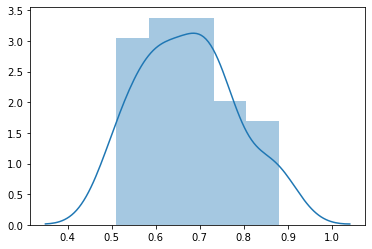

In [97]:
model_prob = [max(i) for i in best_model.predict_proba(pred_copy_df.drop(["Diff"], axis=1))]
sns.distplot(model_prob)

In [98]:
ref_predictions = ref_clf.predict(pred_copy_df[["prev_day"]])
ref_prob = [max(i) for i in ref_clf.predict_proba(pred_copy_df[["prev_day"]])]
accuracy_score(pred_copy_df["Diff"], ref_predictions)

0.5

In [99]:
temp_dow = may_june_dow.copy()
temp_dow["Diff"] = temp_dow["Diff"].shift(-1)

In [100]:
diff_dist = pd.merge(pred_copy_df, temp_dow[["Diff", "Date"]], how="left", left_on="Date", right_on="Date")

In [101]:
diff_dist["model_pred"] = model_predictions
diff_dist["ref_pred"] = ref_predictions

In [102]:
diff_dist = diff_dist[["Date", "Diff_x", "Diff_y", "model_pred", "ref_pred"]]

In [103]:
diff_dist.head()

,Date,Diff_x,Diff_y,model_pred,ref_pred
0,2020-05-04,1.0,75.791015,1.0,1.0
1,2020-05-05,1.0,314.240234,0.0,0.0
2,2020-05-06,0.0,-38.679687,0.0,0.0
3,2020-05-07,0.0,-223.500000,0.0,1.0
4,2020-05-08,1.0,34.458985,1.0,1.0


In [104]:
correct_predictions = diff_dist[diff_dist["Diff_x"] == diff_dist["model_pred"]]
incorrect_predictions = diff_dist[diff_dist["Diff_x"] != diff_dist["model_pred"]]

Plot the distributions of the daily differences for the correct vs incorrect predictions 

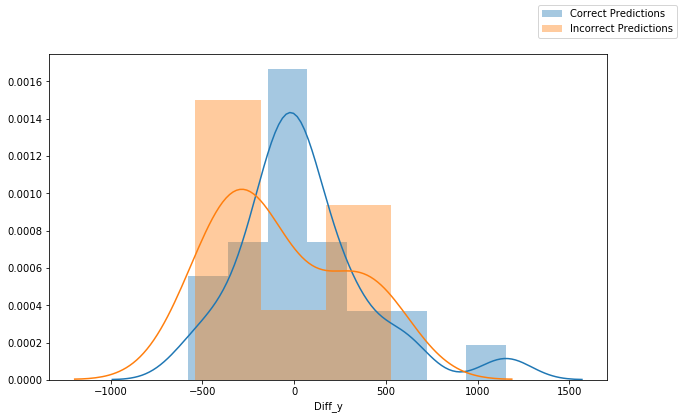

In [105]:
fig = plt.figure(figsize=(10,6))
sns.distplot(correct_predictions["Diff_y"])
sns.distplot(incorrect_predictions["Diff_y"])
fig.legend(labels=['Correct Predictions','Incorrect Predictions'])
plt.savefig("dist_of_model.png")

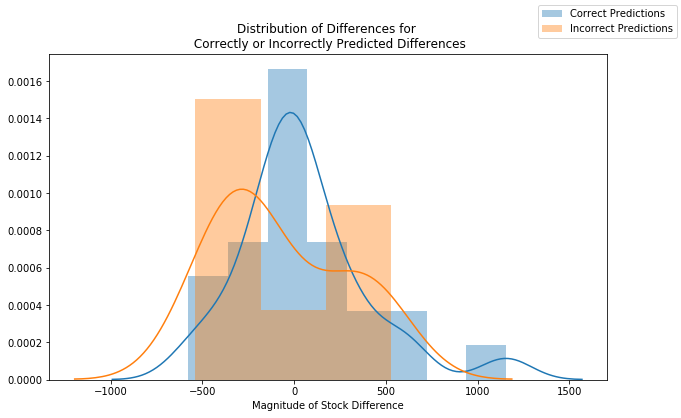

In [115]:
fig = plt.figure(figsize=(10,6))
sns.distplot(correct_predictions["Diff_y"])
sns.distplot(incorrect_predictions["Diff_y"])
fig.legend(labels=['Correct Predictions','Incorrect Predictions'])
plt.xlabel("Magnitude of Stock Difference")
plt.title("Distribution of Differences for \n Correctly or Incorrectly Predicted Differences")
plt.savefig("dist_of_model.png")

In [107]:
diff_dist.head()

,Date,Diff_x,Diff_y,model_pred,ref_pred
0,2020-05-04,1.0,75.791015,1.0,1.0
1,2020-05-05,1.0,314.240234,0.0,0.0
2,2020-05-06,0.0,-38.679687,0.0,0.0
3,2020-05-07,0.0,-223.500000,0.0,1.0
4,2020-05-08,1.0,34.458985,1.0,1.0


In [108]:
diff_dist.replace(0, -1, inplace=True)

Plot the differences through time along with whether each day was predicted correctly or not 

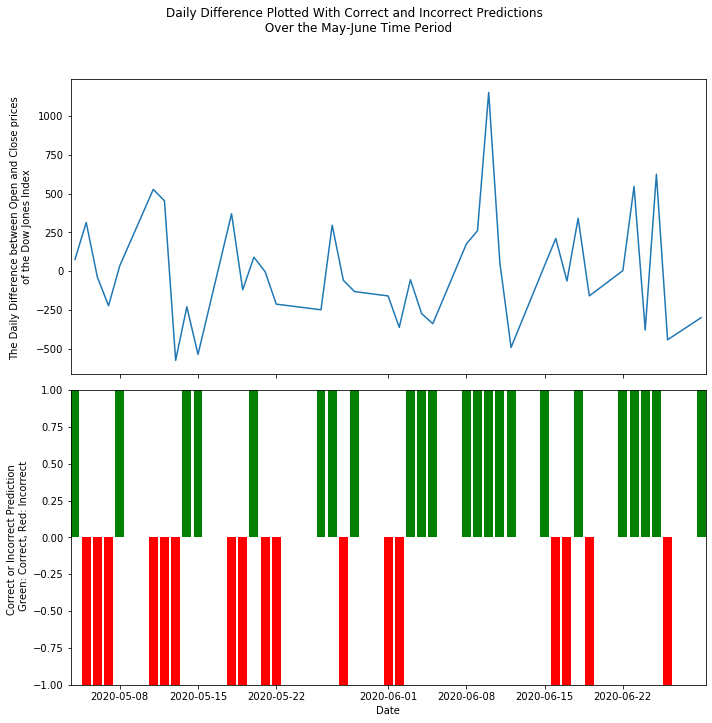

In [116]:

fig, axes = plt.subplots(2, 1, figsize=(10,10),  sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i == 1:
        fig.add_subplot(ax)
        ax.bar(diff_dist["Date"], diff_dist["model_pred"], color=diff_dist["model_pred"].map({1: 'g', -1: 'r'}))
        ax.set_ylabel("Correct or Incorrect Prediction \n Green: Correct, Red: Incorrect")
#         clrs = ['green' if x == 1 else 'red' for x in  diff_dist["model_pred"]]
#         sns.barplot(diff_dist["Date"], diff_dist["model_pred"], palette=clrs)
    else:
        fig.add_subplot(ax)
        sns.lineplot(diff_dist["Date"], diff_dist["Diff_y"])
        ax.set_ylabel("The Daily Difference between Open and Close prices \n of the Dow Jones Index ")
#         ax.plot(diff_dist["Date"], diff_dist["Diff_y"])

plt.subplots_adjust(wspace=0, hspace=0)
fig.suptitle("Daily Difference Plotted With Correct and Incorrect Predictions \n Over the May-June Time Period")
plt.margins(x=0, y=0)
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.xlabel("Date")
plt.savefig("model_pred_time.png")
plt.show()

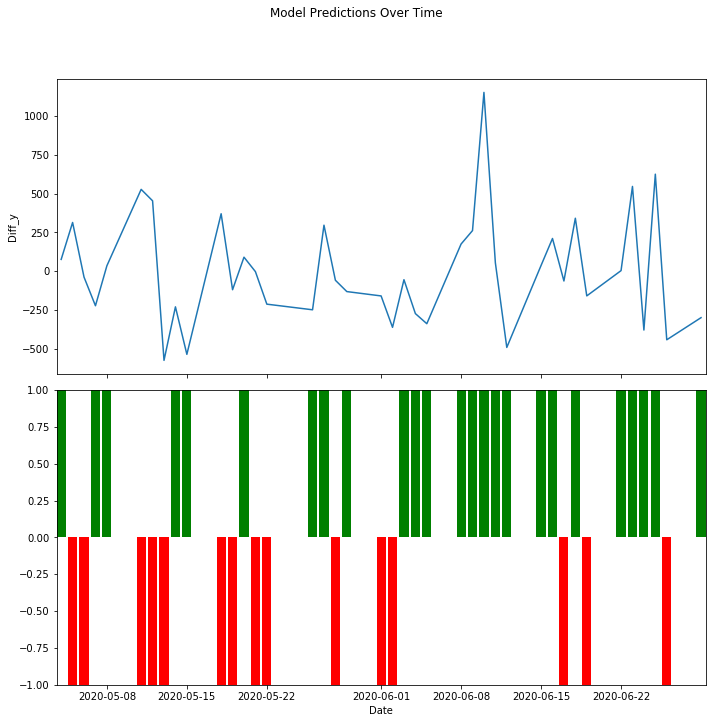

In [251]:

fig, axes = plt.subplots(2, 1, figsize=(10,10),  sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i == 1:
        fig.add_subplot(ax)
        ax.bar(diff_dist["Date"], diff_dist["model_pred"], color=diff_dist["model_pred"].map({1: 'g', -1: 'r'}))
#         clrs = ['green' if x == 1 else 'red' for x in  diff_dist["model_pred"]]
#         sns.barplot(diff_dist["Date"], diff_dist["model_pred"], palette=clrs)
    else:
        fig.add_subplot(ax)
        sns.lineplot(diff_dist["Date"], diff_dist["Diff_y"])
#         ax.plot(diff_dist["Date"], diff_dist["Diff_y"])

plt.subplots_adjust(wspace=0, hspace=0)
fig.suptitle("Model Predictions Over Time")
plt.margins(x=0, y=0)
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.xlabel("Date")
plt.savefig("model_pred_time.png")
plt.show()

### Portfolio testing

In [98]:
def get_file(url, fname):
    filename = requests.get(url)
    f= open(fname, 'wb')
    f.write(filename.content)
    f.close()

Run a simple portfolio

In [163]:
def run_portfolio(predictions, confidence, price, \
                  initial_shares, initial_capital, sensitivity_threshold \
                 ,buy_factor, sell_factor):
    
    shares = [initial_shares]
    capital = [initial_capital] 
    total = [capital[0] + shares[0] * price[0]]


    for i, value in enumerate(predictions):
        if capital[i] != 0 and value == 1 and confidence[i] > sensitivity_threshold:
            curr_price = price[i]
            shares_to_buy = ((capital[i] * buy_factor) // curr_price)
            capital.append(capital[i] - (shares_to_buy * curr_price))
            shares.append(shares[i] + shares_to_buy)

        elif shares[i] > 0 and value == 0 and confidence[i] > sensitivity_threshold:
            curr_price = price[i]
            shares_to_sell = np.ceil(shares[i] * sell_factor)
            capital.append(capital[i] + shares_to_sell * curr_price)
            shares.append(shares[i] - shares_to_sell) 
        else:
            capital.append(capital[i])
            shares.append(shares[i])

        total.append(capital[i] + shares[i] * price[i])
    
    return pd.DataFrame(np.column_stack([capital, shares, total]), 
                               columns=['Capital', 'Number of Shares', 'Total Asset Value'])



In [181]:
def plot_returns(x, df_model, df_ref, name, cap, buy, sell, thresh):
    fig, axes = plt.subplots(3, 1, figsize=(10,10),  sharex=True)
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        sns.lineplot(x, df_model.iloc[:, i][1:], label="Predictive Model")
        sns.lineplot(x, df_ref.iloc[:, i][1:], label="Reference Model")
        ax.legend()
    plt.suptitle("Portfolio of Apple shares \n Initial capital: " \
                 + str(cap) + " Buy Factor: " + str(buy) + "\n Sell Factor: " + str(sell) + " Confidence Threshold " + str(thresh))
    plt.xlabel("Date")
    plt.savefig(name + ".png")
    plt.show()

### Apple

In [132]:
url = "https://query1.finance.yahoo.com/v7/finance/download/AAPL?period1=1588291200&period2=1593648000&interval=1d&events=history"
fname = "apple.csv"

In [133]:
get_file(url, fname)

In [134]:
fname = "apple.csv"
apple = pd.read_csv(fname)
apple["Date"] = pd.to_datetime(apple["Date"])

merged_apple = pd.merge(portfolio_copy, apple, on="Date")
merged_apple["confidence"] = model_prob
merged_apple["diff_pred"] = model_predictions
merged_apple = merged_apple[["Date", "Close", "confidence", "diff_pred"]]

merged_apple_ref = pd.merge(portfolio_copy, apple, on="Date")
merged_apple_ref["confidence"] = ref_prob
merged_apple_ref["diff_pred"] = ref_predictions
merged_apple_ref = merged_apple_ref[["Date", "Close", "confidence", "diff_pred"]]

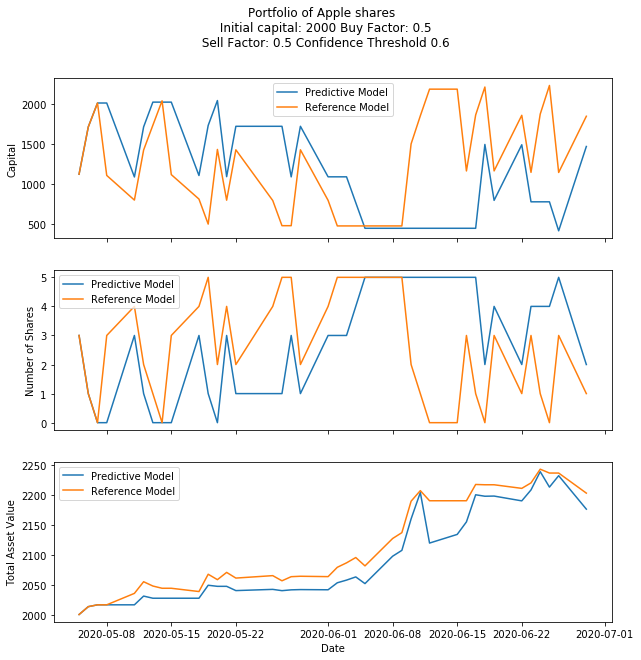

In [184]:
initial_shares = 0
initial_capital = 2000
sensitivity_threshold = 0.6 
buy_factor = 1/2
sell_factor = 1/2

# Calculate for Model
df = merged_apple
return_df = run_portfolio(df["diff_pred"], df["confidence"], df["Close"],
             initial_shares, initial_capital, sensitivity_threshold, buy_factor, sell_factor)

# Calculate for Reference Model
df = merged_apple_ref
return_df_ref = run_portfolio(df["diff_pred"], df["confidence"], df["Close"],
             initial_shares, initial_capital, sensitivity_threshold, buy_factor, sell_factor)

plot_returns(merged_apple["Date"], return_df, return_df_ref, "portfolio_1", initial_capital, buy_factor, sell_factor, sensitivity_threshold)

### United Health Group

In [362]:
fname = "UnitedHealthGroup.csv"
url = "https://query1.finance.yahoo.com/v7/finance/download/UNH?period1=1588291200&period2=1593648000&interval=1d&events=history"

In [344]:
get_file(url, fname)

In [121]:
fname = "UnitedHealthGroup.csv"

unh = pd.read_csv(fname)
unh["Date"] = pd.to_datetime(unh["Date"])

unh_model = pd.merge(portfolio_copy, unh, on="Date")
unh_model["confidence"] = model_prob
unh_model["diff_pred"] = model_predictions
unh_model = unh_model[["Date", "Close", "confidence", "diff_pred"]]

unh_ref = pd.merge(portfolio_copy, unh, on="Date")
unh_ref["confidence"] = ref_prob
unh_ref["diff_pred"] = ref_predictions
unh_ref = unh_ref[["Date", "Close", "confidence", "diff_pred"]]

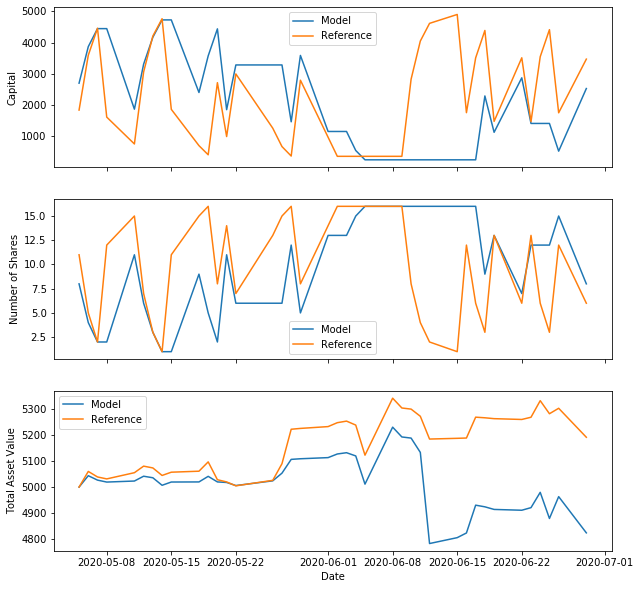

In [138]:
initial_shares = 0
initial_capital = 5000
sensitivity_threshold = 0.6 
buy_factor = 5/6
sell_factor = 5/8

# Calculate for Model
df = unh_model
return_df = run_portfolio(df["diff_pred"], df["confidence"], df["Close"],
             initial_shares, initial_capital, sensitivity_threshold, buy_factor, sell_factor)

# Calculate for Reference Model
df = unh_ref
return_df_ref = run_portfolio(df["diff_pred"], df["confidence"], df["Close"],
             initial_shares, initial_capital, sensitivity_threshold, buy_factor, sell_factor)

plot_returns(unh_model["Date"], return_df, return_df_ref)

### Dow Inc

In [356]:
url = "https://query1.finance.yahoo.com/v7/finance/download/DOW?period1=1588291200&period2=1593648000&interval=1d&events=history"
fname = "DowInc.csv"

In [302]:
get_file(url, fname)

In [117]:
fname = "DowInc.csv"
dow = pd.read_csv(fname)
dow["Date"] = pd.to_datetime(dow["Date"])

dow_inc_model = pd.merge(portfolio_copy, dow, on="Date")
dow_inc_model["confidence"] = model_prob
dow_inc_model["diff_pred"] = model_predictions
dow_inc_model = dow_inc_model[["Date", "Close", "confidence", "diff_pred"]]

dow_inc_ref = pd.merge(portfolio_copy, dow, on="Date")
dow_inc_ref["confidence"] = ref_prob
dow_inc_ref["diff_pred"] = ref_predictions
dow_inc_ref = dow_inc_ref[["Date", "Close", "confidence", "diff_pred"]]

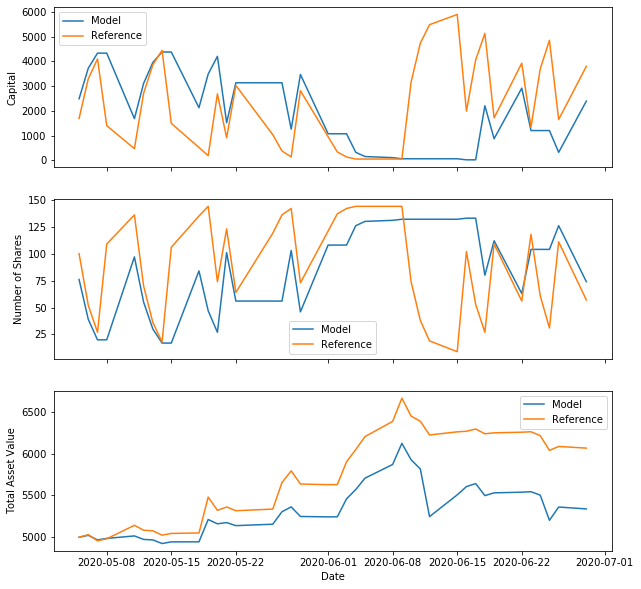

In [139]:
initial_shares = 0
initial_capital = 5000
sensitivity_threshold = 0.6 
buy_factor = 5/6
sell_factor = 5/8

# Calculate for Model
df = dow_inc_model
return_df = run_portfolio(df["diff_pred"], df["confidence"], df["Close"],
             initial_shares, initial_capital, sensitivity_threshold, buy_factor, sell_factor)

# Calculate for Reference Model
df = dow_inc_ref
return_df_ref = run_portfolio(df["diff_pred"], df["confidence"], df["Close"],
             initial_shares, initial_capital, sensitivity_threshold, buy_factor, sell_factor)

plot_returns(dow_inc_model["Date"], return_df, return_df_ref)

In [191]:
X_train.columns

Index(['GoldsteinScale', 'AvgTone', 'prev_day'], dtype='object')

Plot the feature names

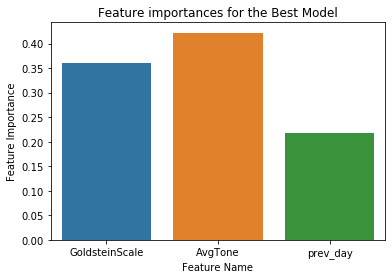

In [194]:
sns.barplot(X_train.columns, best_model.feature_importances_)
plt.xlabel("Feature Name")
plt.ylabel("Feature Importance")
plt.title("Feature importances for the Best Model")
plt.savefig("feature_importance.png")